In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns

import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from IPython import display
import os
#import re
import sys

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

#set path
sys.path.insert(1, '../')

In [2]:
from utils.reader_config import config_reader
from utils.figures import plot_history
from utils.models import callbacks

config = config_reader('../config/config.json')

# fix random seed
random_seed = config.random_seed

# from utils.functions import print_metrics
path_figures = config.path_figures
path_data = config.path_data #os.path.join(config.path_data, 'recordings/') 
path_models = config.path_models
path_data

'../data/'

In [3]:
# read the dataset
print(config.path_data)
train_full_df = pd.read_csv(os.path.join(config.path_data, 'train.csv'))
train_full_df['file_name'] = train_full_df.loc[:, 'filename'].apply(lambda x: x[6:])
train_full_df.head()

../data/


,filename,transcription,spk_id,gender,ext,samplerate,file_name
0,train/0007c21c23.wav,139473,spk_E,female,wav,24000,0007c21c23.wav
1,train/000bee1b1d.wav,992597,spk_B,male,wav,24000,000bee1b1d.wav
2,train/001a718902.wav,500869,spk_A,female,wav,22050,001a718902.wav
3,train/001e8e5565.wav,969908,spk_C,male,wav,22050,001e8e5565.wav
4,train/001ee5be6b.wav,80484,spk_E,female,wav,24000,001ee5be6b.wav


In [6]:
# dataset contains audio files having two distinct rates
train_full_df['samplerate'].value_counts()

samplerate
24000    10424
22050     2129
Name: count, dtype: int64

## Data Exploration

In the first step, the so-called Data Exploration, individual audio recordings are visualized and examined for first visible differences. From the available 3,000 recordings, a random recording is chosen for different digits and visualized as waveform and mel spectrogram.

In [8]:
import librosa

Digit is : 683114


Digit is : 429202


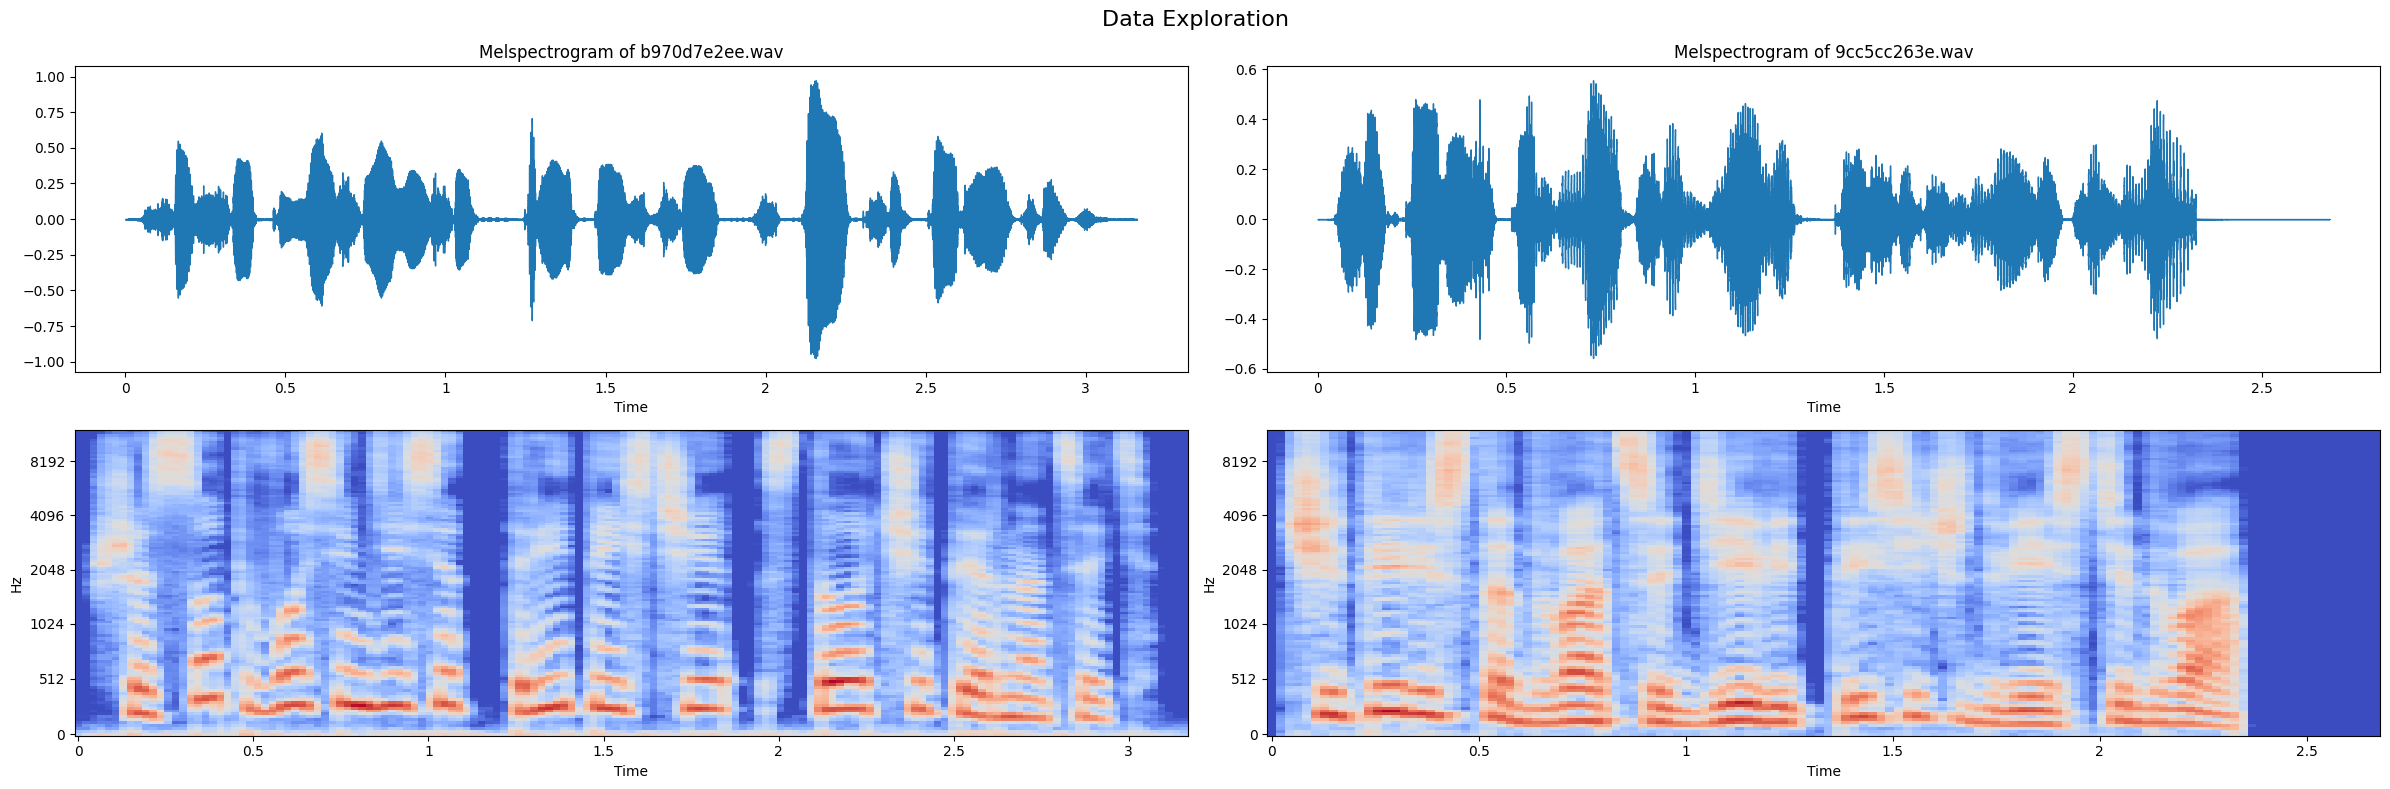

In [4]:
#visualize_digits = [139473, 992597] #
SAMPLE_SIZE = 2
random_seed = 42

sample = train_full_df.sample(n=SAMPLE_SIZE, random_state=random_seed)
digits_list = sample['transcription'].to_list()
description = train_full_df #pd.read_csv(os.path.join(config.path_data, '/train'))

fig, ax = plt.subplots(nrows=2, ncols=(SAMPLE_SIZE)) #train_full_df
ax = ax.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)

for i, digit in enumerate(digits_list):
    # Select random file for selected digit
    rand_file = np.random.choice(
        description[description['transcription'] == digit]['file_name'])
    
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join(path_data, 'train/', rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, axis='time', ax=ax[i])# not waveplot
    
    ax[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    
    librosa.display.specshow(
        data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=ax[i+SAMPLE_SIZE])
    ax[i].set(title=f'Melspectrogram of {rand_file}')
    
    #print('Audio playback')
    print(f'Digit is : {digit}')
    display.display(display.Audio(audio, rate=16000))

plt.tight_layout()
plt.show()

## Feature Engineering

The next step is to extract features from the audio recordings, in this case a Melspectrogram. In order later train the neural network, all features must have the same shape. However, since the recordings are of different lengths, they are brought to a length of 4-6 s by time-stretching. The features and labels of the recordings are stored in numpy arrays to be able to work with them easily later.

In [ ]:
import librosa
import numpy as np
import os
import pandas as pd



In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.filterwarnings('ignore')

# Configuration
TARGET_SR = 16000
TRIM_END_SEC = 0.25
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 256
TRIM_SAMPLES = int(TRIM_END_SEC * TARGET_SR)
FIXED_MEL_FRAMES = 128

# Precompute mel filter bank for consistent results
mel_filter = librosa.filters.mel(sr=TARGET_SR, n_fft=N_FFT, n_mels=N_MELS)

def process_single_file(row, data_path):
    """Process a single audio file and return features and label"""
    file_path = os.path.join(data_path, row['filename'])
    
    # Skip missing files
    if not os.path.exists(file_path):
        return None, None
    
    try:
        # Load audio with optimized parameters
        y, sr = librosa.load(file_path, sr=TARGET_SR, mono=True)
        
        # Trim silence with optimized parameters
        if len(y) > 100:  # Only trim if audio is long enough
            y, _ = librosa.effects.trim(y, top_db=25, frame_length=512, hop_length=128)
        
        # Compute Mel-Spectrogram with precomputed filter
        mels = librosa.feature.melspectrogram(
            y=y, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP_LENGTH, 
            n_mels=N_MELS, fmin=50, fmax=8000, htk=True
        )
        
        # Convert to log-mel spectrogram
        mels_db = librosa.power_to_db(mels, ref=np.max, top_db=80)
        
        # Pad or crop to fixed size
        if mels_db.shape[1] < FIXED_MEL_FRAMES:
            pad_width = FIXED_MEL_FRAMES - mels_db.shape[1]
            mels_db = np.pad(mels_db, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
        else:
            mels_db = mels_db[:, :FIXED_MEL_FRAMES]
        
        # Add channel dimension and return
        return mels_db[..., np.newaxis], row['transcription']
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None, None

def process_files_parallel(df, data_path, max_workers=None):
    """Process files in parallel using ThreadPoolExecutor"""
    feature_list, label_list = [], []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_row = {
            executor.submit(process_single_file, row, data_path): row 
            for _, row in df.iterrows()
        }
        
        # Collect results as they complete
        for future in tqdm(as_completed(future_to_row), total=len(future_to_row), desc="Processing files"):
            features, label = future.result()
            if features is not None and label is not None:
                feature_list.append(features)
                label_list.append(label)
    
    return feature_list, label_list

def process_files_batch(df, data_path, batch_size=100):
    """Process files in batches to manage memory usage"""
    feature_list, label_list = [], []
    
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        batch_df = df.iloc[i:i + batch_size]
        batch_features, batch_labels = process_files_parallel(batch_df, data_path)
        feature_list.extend(batch_features)
        label_list.extend(batch_labels)
    
    return feature_list, label_list

# Main optimized preprocessing function
def preprocess_audio_optimized(train_full_df, path_data, use_parallel=True, batch_processing=True):
    print('Preparing feature dataset and labels (optimized)...')
    
    # Filter out missing files first
    valid_files = []
    for _, row in train_full_df.iterrows():
        file_path = os.path.join(path_data, row['filename'])
        if os.path.exists(file_path):
            valid_files.append(row)
    
    print(f"Found {len(valid_files)} valid files out of {len(train_full_df)}")
    valid_df = pd.DataFrame(valid_files)
    
    if use_parallel:
        if batch_processing and len(valid_df) > 500:
            # Use batch processing for large datasets
            feature_list, label_list = process_files_batch(valid_df, path_data, batch_size=200)
        else:
            # Process all files in parallel
            feature_list, label_list = process_files_parallel(valid_df, path_data)
    else:
        # Sequential processing (fallback)
        feature_list, label_list = [], []
        for _, row in tqdm(valid_df.iterrows(), total=len(valid_df), desc="Processing files sequentially"):
            features, label = process_single_file(row, path_data)
            if features is not None and label is not None:
                feature_list.append(features)
                label_list.append(label)
    
    # Convert to arrays
    features = np.array(feature_list, dtype=np.float32)
    labels = np.array(label_list)
    
    print(f"Done! Feature shape: {features.shape}, Labels: {labels.shape}")
    return features, labels

# # Usage example:
# features, labels = preprocess_audio_optimized(train_full_df, path_data, use_parallel=True)

Preparing feature dataset and labels (optimized)...
Found 12553 valid files out of 12553


Processing batches: 100%|██████████| 63/63 [03:29<00:00,  3.33s/it]


Done! Feature shape: (12553, 128, 128, 1), Labels: (12553,)


In [ ]:
# import pickle
# import hashlib

# def get_data_hash(df, path_data):
#     """Generate hash for dataset to enable caching"""
#     file_info = "".join([f"{row['filename']}{row['transcription']}" for _, row in df.iterrows()])
#     return hashlib.md5(file_info.encode()).hexdigest()

# def preprocess_with_cache(train_full_df, path_data, cache_dir="cache"):
#     """Preprocess with caching to avoid recomputation"""
#     os.makedirs(cache_dir, exist_ok=True)
#     data_hash = get_data_hash(train_full_df, path_data)
#     cache_file = os.path.join(cache_dir, f"features_{data_hash}.pkl")
    
#     if os.path.exists(cache_file):
#         print("Loading cached features...")
#         with open(cache_file, 'rb') as f:
#             return pickle.load(f)
#     else:
#         features, labels = preprocess_audio_optimized(train_full_df, path_data)
#         with open(cache_file, 'wb') as f:
#             pickle.dump((features, labels), f)
#         return features, labels

In [ ]:
# def preprocess_generator(df, path_data, batch_size=32):
#     """Generator for memory-efficient processing"""
#     for i in range(0, len(df), batch_size):
#         batch_df = df.iloc[i:i + batch_size]
#         features, labels = process_files_parallel(batch_df, path_data)
#         if features:  # Only yield if we have data
#             yield np.array(features, dtype=np.float32), np.array(labels)

In [ ]:
TARGET_SR = 16000          # Target sample rate for all files
#TARGET_DURATION = 1.0      # Target audio length in seconds
TRIM_END_SEC = 0.25         # Amount of time (in seconds) to trim from the end
N_MELS = 128               # Number of mel frequency bins
N_FFT = 1024 #2048               # FFT window size
HOP_LENGTH = 256 # 512           # Hop size between frames

# Derived parameters
TRIM_SAMPLES = int(TRIM_END_SEC * TARGET_SR)      # samples to trim from end
FIXED_MEL_FRAMES = 128                             # fixed width of spectrograms

# Lists to store computed features and labels
feature_list, label_list  = [], []

print('Preparing feature dataset and labels...')

# 3. Process file
for _, row in tqdm(train_full_df.iterrows(), total=len(train_full_df)):
    file_path = os.path.join(path_data, row['filename'])
    label = row['transcription']

    # Skip missing files
    if not os.path.exists(file_path):
        continue

    # Step 1: Load and resample audio
    y, sr = librosa.load(file_path, sr=TARGET_SR)
    
    # adaptive silence trimmer
    y, _ = librosa.effects.trim(y, top_db=25)
    # # Trim 500 ms (0.5 s) from the end, if long enough
    # if len(y) > TRIM_SAMPLES:
    #     y = y[:-TRIM_SAMPLES]
    # else:
    #     print(f"Warning: {row['filename']} is shorter than 0.5s — skipping.")
    #     continue
   
    # Step 2: Compute Mel-Spectrogram
    mels = librosa.feature.melspectrogram(
        y=y, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    
    #log-mel spectrogram
    mels_db = librosa.power_to_db(mels, ref=np.max) # Convert power to decibels (log scale)
    
    #mels_db = (mels_db - mels_db.mean()) / (mels_db.std() + 1e-6) # Normalize each spectrogram

   
    # Step 4: Pad or crop along time axis
    # Ensure all spectrograms have the same number of frames
    if mels_db.shape[1] < FIXED_MEL_FRAMES:
        pad_width = FIXED_MEL_FRAMES - mels_db.shape[1]
        mels_db = np.pad(mels_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mels_db = mels_db[:, :FIXED_MEL_FRAMES]

    # ------------------------------------------
    # 🔹 Step 5: Store features and label
    # ------------------------------------------
    feature_list.append(mels_db[..., np.newaxis])  # add channel dimension
    label_list.append(label)

# ==============================================
# 4️⃣ Convert lists to NumPy arrays
# ==============================================
features = np.array(feature_list, dtype=np.float32)
labels = np.array(label_list)

# # Encode labels to integers (optional)
# le = LabelEncoder()
# labels_encoded = le.fit_transform(labels)

print(f"Done! Feature shape: {features.shape}, Labels: {labels.shape}") #labels_encoded.shape

Preparing feature dataset and labels...


100%|██████████| 12553/12553 [04:37<00:00, 45.18it/s]


Done! Feature shape: (12553, 128, 128, 1), Labels: (12553,)


In [ ]:
TARGET_SR = 16000       # Target sample rate for all files
TRIM_END_SEC = 0.25     # Amount of time (in seconds) to trim from the end
N_MELS = 128            # Number of mel frequency bins
N_FFT = 1024            # FFT window size
HOP_LENGTH = 256        # Hop size between frames

# Derived parameters
TRIM_SAMPLES = int(TRIM_END_SEC * TARGET_SR)      # samples to trim from end
FIXED_MEL_FRAMES = 128                            # fixed width of spectrograms

# Lists to store computed features and labels
feature_list, label_list  = [], []

print('Preparing feature dataset and labels...')

# 3. Process file
for _, row in tqdm(train_full_df.iterrows(), total=len(train_full_df)):
    file_path = os.path.join(path_data, row['filename'])
    label = row['transcription']

    # Skip missing files
    if not os.path.exists(file_path):
        continue

    # Step 1: Load and resample audio
    y, sr = librosa.load(file_path, sr=TARGET_SR)
    
    # adaptive silence trimmer
    y, _ = librosa.effects.trim(y, top_db=25)
   
    # Step 2: Compute Mel-Spectrogram
    mels = librosa.feature.melspectrogram(
        y=y, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    
    #log-mel spectrogram
    mels_db = librosa.power_to_db(mels, ref=np.max) # Convert power to decibels (log scale)
    

    # Step 4: Pad or crop along time axis
    # Ensure all spectrograms have the same number of frames
    if mels_db.shape[1] < FIXED_MEL_FRAMES:
        pad_width = FIXED_MEL_FRAMES - mels_db.shape[1]
        mels_db = np.pad(mels_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mels_db = mels_db[:, :FIXED_MEL_FRAMES]

    # ------------------------------------------
    # Step 5: Store features and label
    # ------------------------------------------
    feature_list.append(mels_db[..., np.newaxis])  # add channel dimension
    label_list.append(label)

# ==============================================
# Convert lists to NumPy arrays
# ==============================================
features = np.array(feature_list, dtype=np.float32)
labels = np.array(label_list)

print(f"Done! Feature shape: {features.shape}, Labels: {labels.shape}") #labels_encoded.shape

In [ ]:
#import librosa, os, soundfile as sf

In [ ]:
# TARGET_SR = 16000           # Target sample rate for all files
# TRIM_END_SEC = 0.25         # Amount of time (in seconds) to trim from the end
# N_MELS = 128                # Number of mel frequency bins
# N_FFT = 1024                # FFT window size
# HOP_LENGTH = 256            # Hop size between frames

# # Derived parameters
# TRIM_SAMPLES = int(TRIM_END_SEC * TARGET_SR)      # samples to trim from end
# FIXED_MEL_FRAMES = 128                             # fixed width of spectrograms

# # Parallel processing
# # ==========================

# # Lists to store computed features and labels
# feature_list, label_list  = [], []

# print('Preparing feature dataset and labels...')

# # Precompute mel filterbank (reuse for speed)
# mel_filterbank = librosa.filters.mel(sr=TARGET_SR, n_fft=N_FFT, n_mels=N_MELS)

# def process_audio(row):
#     file_path = os.path.join(path_data, row["filename"])
#     label = row["transcription"]

#     if not os.path.exists(file_path):
#         return None

#     try:
#         # Step 1: Fast load (soundfile) — no decoding overhead
#         y, sr = librosa.read(file_path, dtype="float32") #sf.read(file_path, dtype="float32")
#         if sr != TARGET_SR:
#             y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
        
#         # Step 2: Trim silence quickly (no energy-based adaptive scan)
#         y = y[: len(y) - TRIM_SAMPLES] if len(y) > TRIM_SAMPLES else y
#         y, _ = librosa.effects.trim(y, top_db=25)

#         # Step 3: Compute Mel-spectrogram manually (reuse filterbank)
#         S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)) ** 2
#         mels = np.dot(mel_filterbank, S)
#         mels_db = librosa.power_to_db(mels, ref=np.max)

#         # Step 4: Fix shape
#         mels_db = (
#             np.pad(mels_db, ((0, 0), (0, max(0, FIXED_MEL_FRAMES - mels_db.shape[1]))), mode="constant")
#             if mels_db.shape[1] < FIXED_MEL_FRAMES
#             else mels_db[:, :FIXED_MEL_FRAMES]
#         )

#         return mels_db[..., np.newaxis], label

#     except Exception as e:
#         print(f"Error with {file_path}: {e}")
#         return None


# from joblib import Parallel, delayed

# # Parallel processing
# results = Parallel(n_jobs=-1, backend="loky", verbose=5)(
#     delayed(process_audio)(row)
#     for _, row in tqdm(train_full_df.iterrows(), total=len(train_full_df))
# )

# features = np.array(results, dtype=np.float32)
# labels = train_full_df['transcription'].values #np.array(labels)

# print(f"Done! Feature shape: {features.shape}, Labels: {labels.shape}")

Preparing feature dataset and labels...


In [ ]:
# # ==============================================
# # 5️⃣ Optional: Visualize one example
# # ==============================================
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 4))
# librosa.display.specshow(features[0].squeeze(), sr=TARGET_SR, x_axis='time', y_axis='mel')
# plt.title(f"Mel-spectrogram example (Label: {labels[0]})")
# plt.colorbar(format="%+2.0f dB")
# plt.show()


In [ ]:
# feature_list, label_list = [], []

# # Iterate over all files in given source path
# print('Preparing feature dataset and labels.')
# for file in tqdm(os.listdir(path_data + 'train/')):
#     # Skip if it's not a wav file
#     if not file.endswith('.wav'):
#         continue
    
#     # Load audio and stretch it to length 1s
#     audio_path = os.path.join(path_data, 'train/', file)
#     audio, sr = librosa.load(path=audio_path, sr=None)
#     #audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    
#     # Calculate features and get the label from the filename
#     mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
#     mels_db = librosa.power_to_db(S=mels, ref=1.0)
#     feature_list.append(mels_db.reshape((128, 16, 1)))
#     label_list.append(file[0])
    
# features = np.array(feature_list)
# #np.array(label_list)

## Model Architecture

After the data is prepared, the next step is to define the architecture or the structure of the neural network. Using the Keras Sequential API, the individual layers can be defined one after the other.

1. Input layer: In the first layer it is only defined which form the incoming data has. This does not necessarily be entered as a separate layer, but can also be defined in the subsequent layer.
Conv2D Layers & MaxPooling: The next part is the core of CNNs. Within the Convolutional Layers possible relevant correlations are determined from the data by kernels. The first number indicates in each case, how many filters are to be generated. The MaxPooling layer reduces the output of the previous layers by again running a kernel over the data and selecting the largest value from a 2×2 field.
2. Flatten & Dropout: The Flatten layer generates a 1-dimensional tensor/vector from an n-dimensional input. The Dropout layer randomly deactivates the given fraction of neurons per epoch. By this methodology the so-called overfitting (overfitting to the training data) can be reduced. 4 Dense 
3. Layers: Finally, the CNN contains a Dense Layer with 64 neurons as well as the actual classifier (layer with 10 neurons, one for each class). Through the Softmax activation function, values between 0 and 1 are emitted which can be seen as the probability for each class.

The network is then compiled with an optimizer, loss function as well as metrics.

In [9]:
labels

array([278484, 770256, 139473, ..., 539082, 231715, 834198])

In [10]:
# normalize features and the target
Normalization_layer = keras.layers.Normalization()   # default axis=-1 (per-channel)
# features_train is your numpy array with shape (N, 128, 128, 1)
Normalization_layer.adapt(features)      # computes mean, variance, count from training set

from sklearn.preprocessing import MinMaxScaler
import joblib

scaler_y = MinMaxScaler()
labels_scaled = scaler_y.fit_transform(np.array(labels).reshape(-1, 1))
joblib.dump(scaler_y, os.path.join(path_models, 'scaler_labels.joblib'))

['../models/scaler_labels.joblib']

In [11]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=features[0].shape),
    Normalization_layer,  # normalize inputs
    keras.layers.Resizing(16, 16),

    # Block 1
    keras.layers.Conv2D(32, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),

    # Block 2
    keras.layers.Conv2D(64, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    

    # Block 3
    keras.layers.Conv2D(128, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),

    # Block 4
    keras.layers.Conv2D(256, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
     
    # Block 5
    keras.layers.Conv2D(512, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(2, 2),

    # Block 6
    # keras.layers.Conv2D(1024, 3, padding='same', use_bias=False),
    # keras.layers.BatchNormalization(),
    # keras.layers.Activation('relu'),
    keras.layers.GlobalAveragePooling2D(),  # more compact than Flatten
    
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1) 
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.callbacks['lr']),
    loss='mse', #tf.keras.losses.MeanSquaredError()
    metrics=['mse'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 128, 128, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 2,007,172 (7.66 MB)

 Trainable params: 2,005,185 (7.65 MB)

 Non-trainable params: 1,987 (7.77 KB)

In [ ]:
config.callbacks = {
    "model_name":"Model_voice",
    "cooldown_epochs":0,
    "lr":1e-1,
    # "min_lr":1e-8,
    "reduce_patience":5,
    "stop_patience":700,
    "verbose":0,
    "monitor":"val_loss",
    "mode":"auto",
    "save_weights_only":True,
    "save_best_only": True,
    "restore_best_weights": True,
    "factor": 0.75
}

In [12]:
# Set parameters for data splitting and training
TEST_SIZE = 0.2
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels_scaled, test_size=TEST_SIZE) #encoded_labels.numpy()

In [ ]:
# from utils.models import  callbacks 
# from IPython.display import clear_output

# # # Train the model
# # early_stopping = keras.callbacks.EarlyStopping(
# #     monitor='val_loss', patience=10, restore_best_weights=True)

# BATCH_SIZE = 64
# EPOCHS = 10
# history = model.fit(
#     x=X_train, 
#     y=y_train, 
#     validation_split=TEST_SIZE,
#     validation_data=(X_test, y_test),
#     epochs=EPOCHS, 
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     callbacks=callbacks(path_models=path_models, **config.callbacks) #[early_stopping]
# )

# clear_output(wait=False)
# plot_history(history, path_figures='../figures/')#, plot_counter=36

## Evaluate the model

After training, the accuracy on new data can be determined using the test set that the model has not seen before. This indicates whether overfitting or underfitting is present, or the training has achieved a good result.

The results of the prediction can be displayed in a confusion matrix. This shows which class a recording really has and which class the model predicted. In the main diagonal the correct predictions can be found

In [13]:
model.load_weights('../models/Model_voice.weights.h5')

In [19]:
y_pred = model.predict(x=X_test)#, axis=1)y_test

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step


In [21]:
model.evaluate(y_pred, y_test)

ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

In [ ]:
# Loads the weights
#model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
y_predicted = model.predict(x=X_test)#, axis=1)

79/79 [==============================] - 38s 474ms/step


In [ ]:
Normalization_layer.weights[0]

tensorflow.python.eager.polymorphic_function.polymorphic_function.UnliftedInitializerVariable

In [ ]:
y_predicted

array([[-0.0038205 ],
       [-0.00297204],
       [-0.00646373],
       ...,
       [-0.00724855],
       [-0.008799  ],
       [-0.00414441]], dtype=float32)

In [ ]:
scaler_y.inverse_transform(y_predicted)

array([[-3806.0232],
       [-2957.6626],
       [-6448.92  ],
       ...,
       [-7233.639 ],
       [-8783.893 ],
       [-4129.884 ]], dtype=float32)

In [ ]:
from tensorflow.keras.models import load_model
model_loaded = load_model('../models/Model_voice.weights.h5')

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000002A5BE5D98A0>.

In [ ]:
model.evaluate(X_test, return_dict=True)

79/79 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00


{'loss': 0.0, 'mse': 0.0}

In [ ]:
from sklearn.metrics  import  mean_squared_error, mean_absolute_percentage_error

print('MSE score:  {:.3f}'.format(mean_squared_error(test_data['Consumption'], pred)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(test_data['Consumption'], pred)))

29/29 [==============================] - 0s 6ms/step


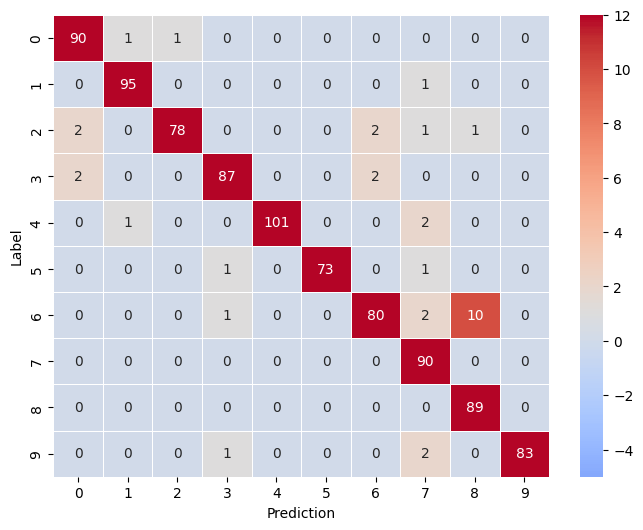

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
mask = np.triu(confusion_matrix)
fig = plt.figure()
fig.set_size_inches(8, 6)

sns.heatmap(
    confusion_matrix, 
    xticklabels=label_names, 
    yticklabels=label_names, annot=True, fmt='g',  cmap='coolwarm',linewidths=.5, vmin=-5, vmax=12, center=1) # Set desired rang)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))